In [ ]:
!nvidia-smi

Mon Feb 26 19:56:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
! pip install rasterio
#helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 37.2 MB/s eta 0:00:00
--2024-02-26 19:56:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-26 19:56:13 (73.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import List, Any, Tuple
import glob
import numpy as np
import geopandas as gpd

import rasterio
from rasterio import mask
from rasterio.plot import reshape_as_image
import regex as re

from skimage import exposure
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import geopandas as gpd

import random
import cv2

from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.callbacks  import (ReduceLROnPlateau, CSVLogger, ModelCheckpoint, EarlyStopping)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/train.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
tif_dir = "/content/train"

tif_files = sorted(glob.glob(os.path.join(tif_dir, "*.tif")))

shp_dir = "/content/train"

shp_files = sorted(glob.glob(os.path.join(shp_dir, "*.shp")))

In [ ]:
def read_vector_file(shp_path: str) -> gpd.GeoDataFrame:
    """Read vector file and return GeoPandas Dataframe.

    Args:
        shp_path: Vector file path.
S
    Returns:
        shp: GeoPandas DataFrame.

    """
    return gpd.read_file(shp_path, mode='r')

def convert_vector_to_array(vectorfile: gpd.GeoDataFrame) -> np.ndarray:
    """Convert vector file to the array of geometry objects.

    Args:
        vectorfile: Geopandas dataframe.

    Returns:
        np.ndarray: Array of geometry objects (e.g.: polygons, multipolygons).

    """
    return np.array(vectorfile["geometry"].values)

def mask_raster(raster: rasterio.io.DatasetReader, geometry_objects: np.ndarray) -> Tuple[Any, Any]:
    """Generate binary mask from raster and array of geometry objects.

    Args:
        raster: Raster object.
        geometry_objects: Array of geometry_objects.

    Returns: Tuple[np.array: binary mask array, aff: affine.Affine]

    """
    return mask.raster_geometry_mask(raster, geometry_objects, invert=True)

## Split image into smaller patches

In [ ]:
# import shutil
# import os

# directory = "/content/patches"
# files_in_directory = os.listdir(directory)

# for file in files_in_directory:
#     try:
#         path_to_file_or_folder = os.path.join(directory, file)
#         shutil.rmtree(path_to_file_or_folder)
#     except:
#         os.unlink(path_to_file_or_folder)

In [ ]:
from PIL import Image
image_directory = "/content/patches/image_patches/img"
mask_directory = "/content/patches/mask_patches/img"

if not os.path.exists(image_directory):
    os.makedirs(image_directory)
if not os.path.exists(mask_directory):
    os.makedirs(mask_directory)

scaler = MinMaxScaler()
image_dataset = []
mask_dataset = []
for img, msk in zip(tif_files,shp_files):
    with rasterio.open(img, "r") as src:
        image = src.read([1, 2, 3]).transpose([1,2,0])
        raster_meta = src.meta


    # im = Image.open(img).convert("RGB")
    # image = np.array(im)

    images = tf.expand_dims(image, 0)
    image_patches = tf.image.extract_patches(images=images,
                                        sizes=[1, 128, 128, 1],
                                        strides=[1, 128, 128, 1],
                                        rates=[1, 1, 1, 1],
                                        padding='SAME')

    patched_img = tf.reshape(image_patches, shape=(image_patches.shape[1]*image_patches.shape[2], 128, 128, 3)).numpy()
    for i in patched_img:
      single_patch_img = i
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      image_dataset.append(single_patch_img)


    name = re.findall('\d+',img)[0]
    if len(name)== 1:
      name = '0'+name



    for i, img in enumerate(patched_img):
        if len(str(i))==1:
          i = '0'+str(i)
        filename = os.path.join(image_directory, f"image_patches_{name}_{i}_{image_patches.shape[1]}_{image_patches.shape[2]}.png")
        cv2.imwrite(filename, img)

    name = re.findall('\d+',msk)[0]
    if len(name)== 1:
      name = '0'+name
    vector_file = read_vector_file(msk)
    geometry_objects = convert_vector_to_array(vector_file)
    binary_mask, _, _ = mask_raster(src, geometry_objects)
    masks = cv2.cvtColor(np.array(binary_mask, dtype=np.uint8), cv2.COLOR_GRAY2RGB)
    masks = tf.expand_dims(masks, 0)
    mask_patches = tf.image.extract_patches(images=masks,
                                        sizes=[1, 128, 128, 1],
                                        strides=[1, 128, 128, 1],
                                        rates=[1, 1, 1, 1],
                                        padding='SAME')

    patched_msk = tf.reshape(mask_patches, shape=(mask_patches.shape[1]*mask_patches.shape[2], 128, 128, 3)).numpy().astype("uint8")
    for i in patched_msk:
      single_patch_mask = i
      single_patch_mask = cv2.cvtColor(single_patch_mask, cv2.COLOR_BGR2GRAY).reshape((128,128,1))
      mask_dataset.append(single_patch_mask)
    for i, m in enumerate(patched_msk):
        if len(str(i))==1:
          i = '0'+str(i)
        filename = os.path.join(mask_directory, f"mask_patches_{name}_{i}_{mask_patches.shape[1]}_{mask_patches.shape[2]}.png")
        cv2.imwrite(filename, m*255)
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (1174, 128, 128, 3)
Mask data shape is:  (1174, 128, 128, 1)
Max pixel value in image is:  1.0000000000000002
Labels in the mask are :  [0 1]


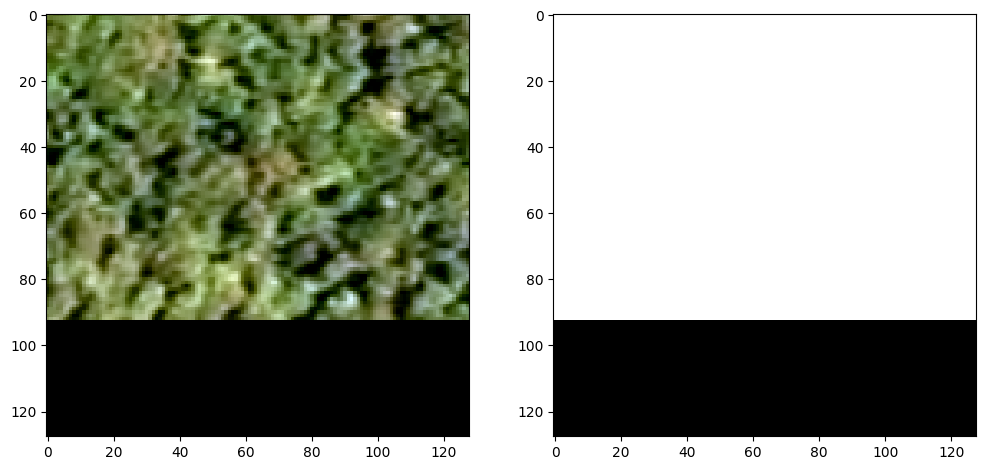

In [ ]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number]*255, cmap='gray')
plt.show()

In [ ]:
# plt.figure(figsize=(10, 10))
# for imgs in image_patches:
#     count = 0
#     for r in range(6):
#         for c in range(7):
#             ax = plt.subplot(6, 7, count+1)
#             plt.imshow(tf.reshape(imgs[r,c],shape=(128,128,3)).numpy())
#             count += 1
# plt.show()
# for imgs in mask_patches:
#     count = 0
#     for r in range(6):
#         for c in range(7):
#             ax = plt.subplot(6, 7, count+1)

#             plt.imshow(tf.reshape(imgs[r,c],shape=(128,128,3)).numpy()*255)
#             count += 1

## Loading Data

In [ ]:
data_gen_args = dict(rotation_range = 90,
                   zoom_range = 0.2,
                   fill_mode = 'reflect',
                   width_shift_range = 0.2,
                   height_shift_range = 0.2,
                   horizontal_flip = True,
                   vertical_flip = True,
                   validation_split=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_datagen.fit(image_dataset, augment=True, seed=seed)
mask_datagen.fit(mask_dataset, augment=True, seed=seed)

image_generator = image_datagen.flow(image_dataset,
                                     y=None,
                                     batch_size=16,
                                     seed = seed,
                                     subset = 'training')

mask_generator = mask_datagen.flow(mask_dataset,
                                     y=None,
                                     batch_size=16,
                                     seed = seed,
                                     subset = 'training')
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

# image_datagen.fit(image_dataset, augment=False, seed=seed)
# mask_datagen.fit(mask_dataset, augment=False, seed=seed)


val_img = image_datagen.flow(image_dataset,
                                     y=None,
                                     batch_size=16,
                                     seed = seed,
                                     subset = 'validation')
val_msk = mask_datagen.flow(mask_dataset,
                                     y=None,
                                     batch_size=16,
                                     seed = seed,
                                     subset = 'validation')

val_generator = zip(val_img, val_msk)




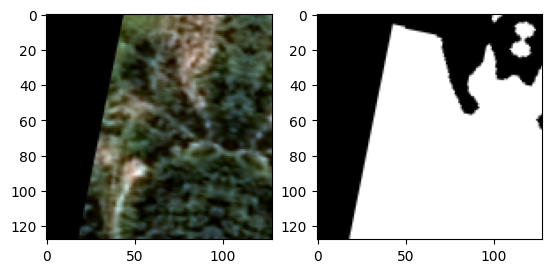

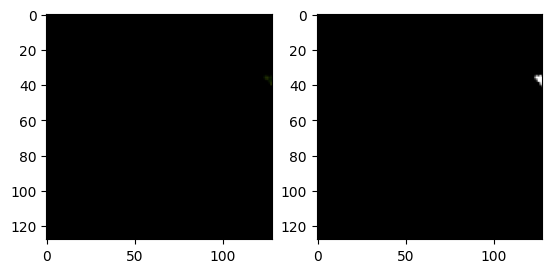

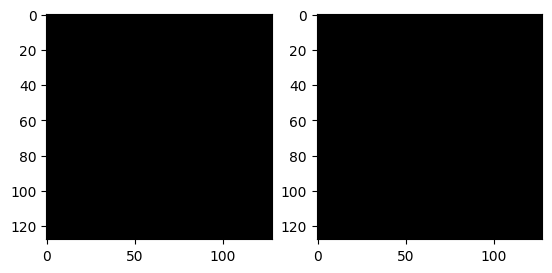

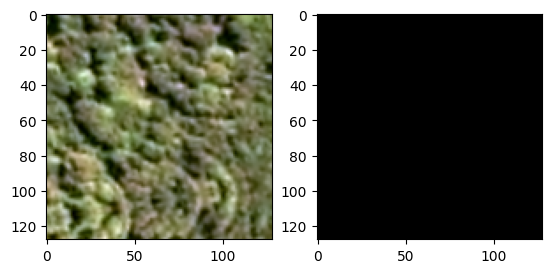

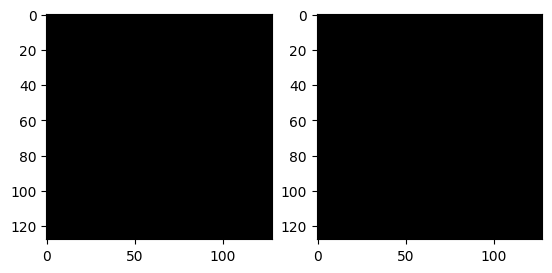

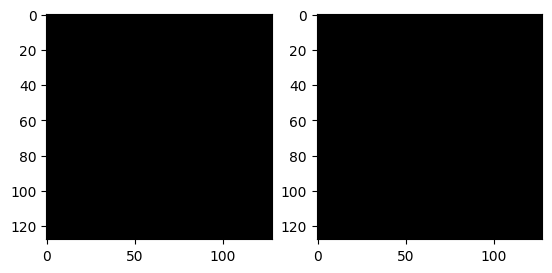

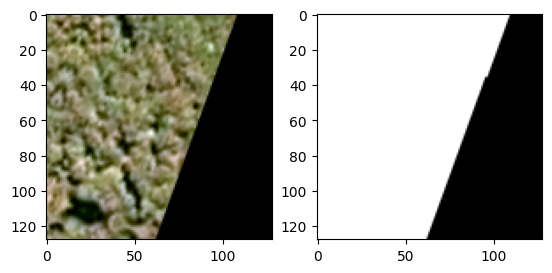

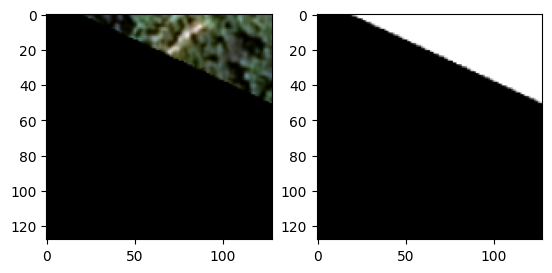

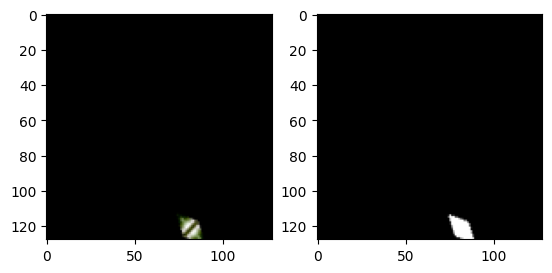

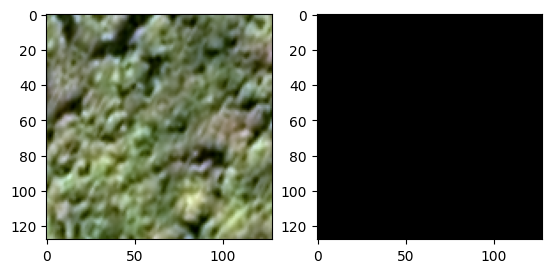

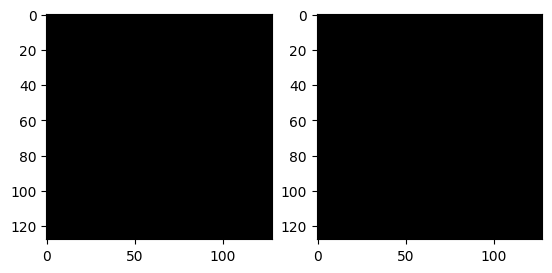

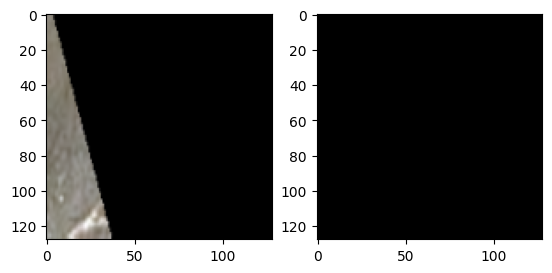

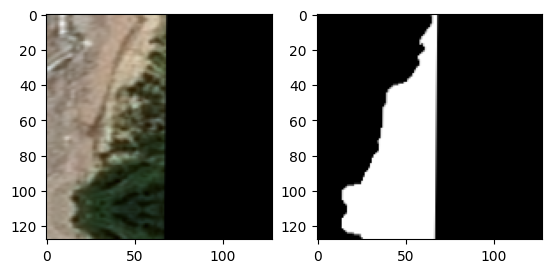

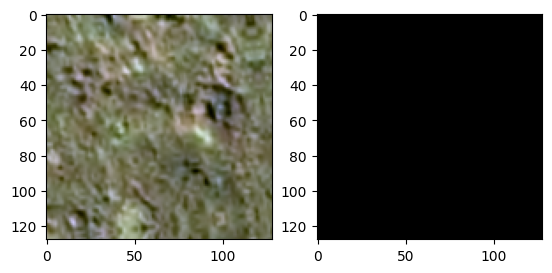

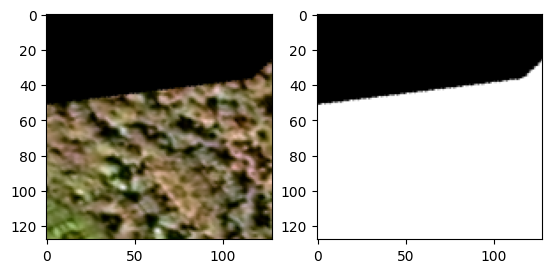

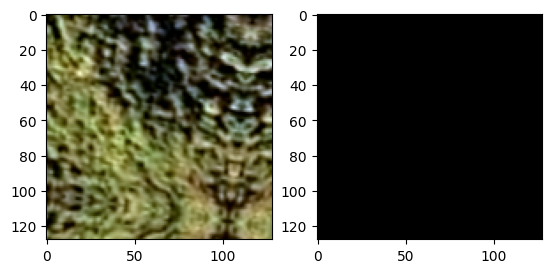

In [ ]:
# Visualizing patched image and mask pairs form generator
# x, y = train_generator.__next__()
# for i in range(0,4):
#     image = x[i]
#     mask = y[i]
#     plt.subplot(1,2,1)
#     plt.imshow(image)
#     plt.subplot(1,2,2)
#     plt.imshow(mask, cmap='gray')
#     plt.show()

x, y = val_generator.__next__()
for i in range(0,16):
    image = x[i]
    mask = y[i]

    plt.subplot(1,2,1)

    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

## Model

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(input)
    # x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(x)
    # x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes, filters=32):
    droprate = 0.25
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    #p2 = Dropout(droprate)(p2)
    s3, p3 = encoder_block(p2, 256)
    # p3 = Dropout(droprate)(p3)
    s4, p4 = encoder_block(p3, 512)
    # p4 = Dropout(droprate)(p4)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    # d1 = Dropout(droprate)(d1)
    d2 = decoder_block(d1, s3, 256)
    # d2 = Dropout(droprate)(d2)
    d3 = decoder_block(d2, s2, 128)
    #d3 = Dropout(droprate)(d3)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, activation = activation, padding="same")(d4)  #Change the activation based on n_classes


    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
# save best model with maximum validation accuracy
model_checkpoint_filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(model_checkpoint_filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
# stop model training early if validation loss doesn't continue to decrease over 10 iterations
early_stopping = EarlyStopping(monitor="val_loss", patience=20, verbose=1)

# create list of callbacks
callbacks_list = [reduce_lr, checkpoint, early_stopping]  # early_stopping


unet_model = build_unet((128,128,3), n_classes=1)
# unet_model.summary()

In [ ]:
# import keras
# keras.backend.clear_session()

In [ ]:
# unet_model.compile(optimizer=Adam(learning_rate = 1e-3),
#                    loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,gamma=2), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
unet_model.compile(optimizer=Adam(learning_rate = 1e-4),
                    loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,gamma=2),
                   metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5,name='BinaryIOU')])

unet_history = unet_model.fit(train_generator,
                    batch_size = 16,
                    verbose=1,
                    epochs=50,
                    steps_per_epoch=len(image_generator),
                    validation_data=val_generator,
                    validation_steps = len(val_img),
                    callbacks=callbacks_list)

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.7324 - auc: 0.8044 - BinaryIOU: 0.5785
Epoch 00001: val_accuracy improved from -inf to 0.95811, saving model to weights.best.hdf5
59/59 [==============================] - 42s 347ms/step - loss: 0.0581 - accuracy: 0.7324 - auc: 0.8044 - BinaryIOU: 0.5785 - val_loss: 0.0144 - val_accuracy: 0.9581 - val_auc: 0.9932 - val_BinaryIOU: 0.9219 - lr: 1.0000e-04
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.8917 - auc: 0.9641 - BinaryIOU: 0.8029
Epoch 00002: val_accuracy improved from 0.95811 to 0.96268, saving model to weights.best.hdf5
59/59 [==============================] - 19s 315ms/step - loss: 0.0271 - accuracy: 0.8917 - auc: 0.9641 - BinaryIOU: 0.8029 - val_loss: 0.0129 - val_accuracy: 0.9627 - val_auc: 0.9961 - val_BinaryIOU: 0.9346 - lr: 1.0000e-04
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9237 - auc: 0.9797 -

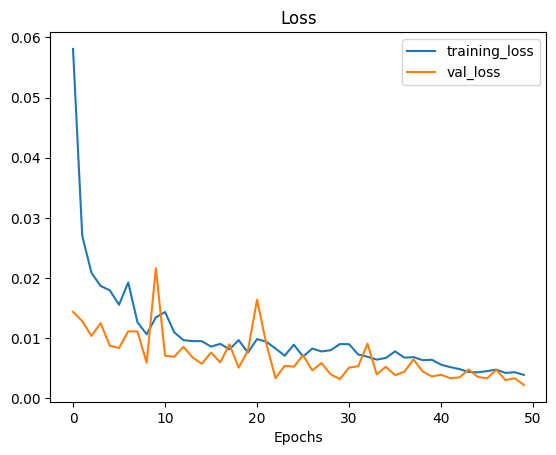

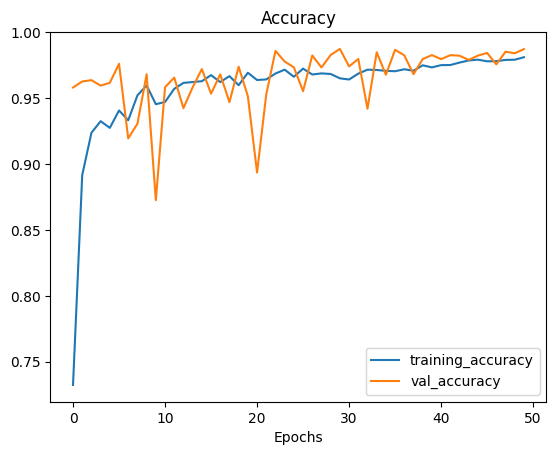

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(unet_history)

In [ ]:
print(max(unet_history.history[('val_BinaryIOU')]))

0.980192244052887


In [ ]:
def plot_predicted_image(image, mask, model, threshold = 0.5):
  test_img_number = random.randint(0, len(image)-1)
  num = random.randint(0, mask[test_img_number].shape[0]-1)
  test_img = image[test_img_number][num]
  ground_truth=mask[test_img_number][num]
  test_img_input=np.expand_dims(test_img, 0)
  print(test_img_number,num)

  print(test_img_input.shape)
  prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
  print(prediction.shape)

  plt.figure(figsize=(16, 8))
  plt.subplot(241)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(242)
  plt.title('Prediction on test image')
  plt.imshow(prediction, cmap = 'gray',vmin=0,vmax=1)



  plt.show()

8 3
(1, 128, 128, 3)
1/1 [==============================] - 0s 18ms/step
(128, 128)


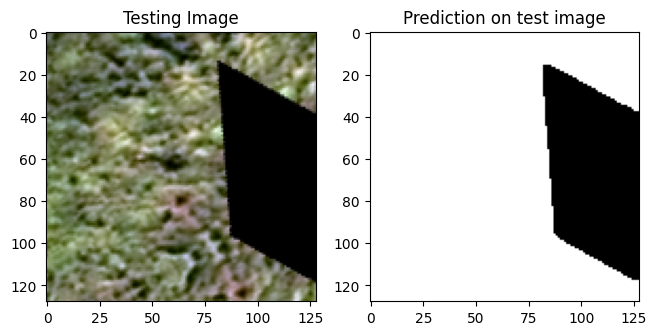

In [ ]:
plot_predicted_image(val_img,val_msk, unet_model)

## Predicting Test Image

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/test.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
test_path = '/content/test/test.tif'
with rasterio.open(test_path, "r") as src:
  image = src.read([1, 2, 3]).transpose([1,2,0])

In [ ]:
with rasterio.open(test_path, "r") as src:
        image = src.read([1, 2, 3]).transpose([1,2,0])

test_image_dataset=[]
images = tf.expand_dims(image, 0)
image_patches = tf.image.extract_patches(images=images,
                                        sizes=[1, 128, 128, 1],
                                        strides=[1, 128, 128, 1],
                                        rates=[1, 1, 1, 1],
                                        padding='SAME')
patched_img = tf.reshape(image_patches, shape=(image_patches.shape[1]*image_patches.shape[2], 128, 128, 3)).numpy()
for i in patched_img:
  single_patch_img = i
  single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
  test_image_dataset.append(single_patch_img)
test_image_dataset = np.array(test_image_dataset)

In [ ]:
image_patches.shape

TensorShape([1, 4, 7, 49152])

In [ ]:
test_image_dataset.reshape(1,4,7,49152).shape

(1, 4, 7, 49152)

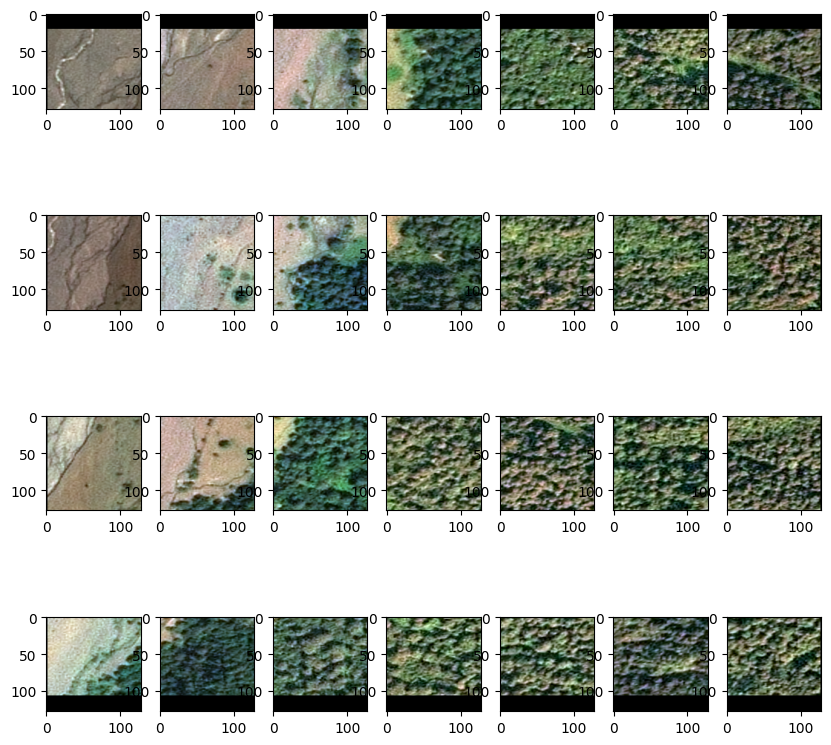

In [ ]:
import logging
plt.figure(figsize=(10, 10))
for imgs in test_image_dataset.reshape(1,4,7,49152):
    count = 0
    for r in range(4):
        for c in range(7):
            logger = logging.getLogger()
            old_level = logger.level
            logger.setLevel(100)
            ax = plt.subplot(4, 7, count+1)
            plt.imshow(tf.reshape(imgs[r,c],shape=(128,128,3)).numpy())
            logger.setLevel(old_level)
            count += 1
plt.show()
# for imgs in mask_patches:
#     count = 0
#     for r in range(6):
#         for c in range(7):
#             ax = plt.subplot(6, 7, count+1)

#             plt.imshow(tf.reshape(imgs[r,c],shape=(128,128,3)).numpy()*255)
#             count += 1

In [ ]:
prediction = unet_model.predict(test_image_dataset)
test_pred = (np.squeeze(prediction) > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 21ms/step


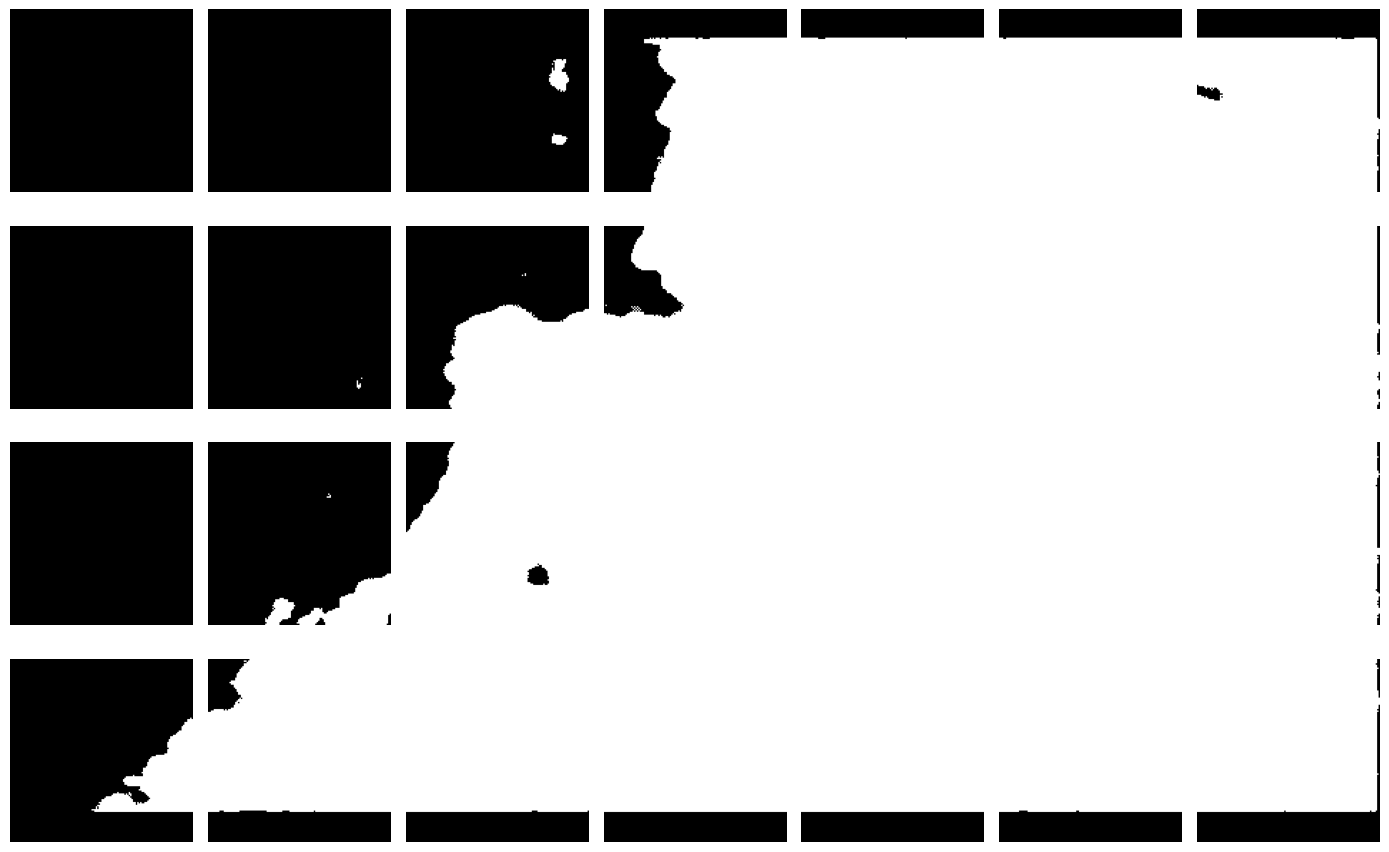

In [ ]:

# Create a figure and subplots
fig, axs = plt.subplots(4, 7, figsize=(14, 9))

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Iterate through each predicted mask and plot it on a subplot
for i, mask in enumerate(test_pred):
    axs[i].imshow(mask, cmap='gray', vmin =0, vmax=1)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


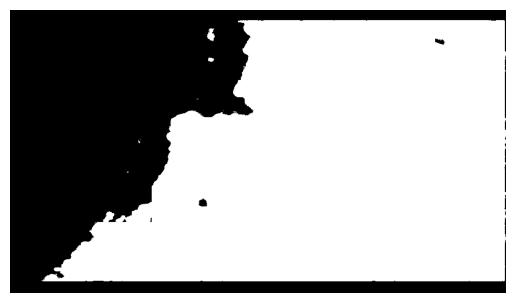

In [ ]:
patch_height, patch_width = test_pred[0].shape

# Assuming you have 28 patches arranged in 4 rows and 7 columns
num_rows = 4
num_cols = 7

# Initialize an empty array to store the reconstructed image
reconstructed_image = np.zeros((num_rows * patch_height, num_cols * patch_width))

# Iterate through each patch and place it in the reconstructed image
for i, patch in enumerate(test_pred):
    row_index = i // num_cols
    col_index = i % num_cols
    start_row = row_index * patch_height
    end_row = start_row + patch_height
    start_col = col_index * patch_width
    end_col = start_col + patch_width
    reconstructed_image[start_row:end_row, start_col:end_col] = patch

# Display the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
reconstructed_image.shape

(512, 896)